# All GITM plots and Data Analysis used in the Sim Storm Paper

## Imports

In [1]:
import time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import glob
import datetime
from aetherpy.io import read_routines
from scipy import signal


import sys
import geopandas




<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [ ]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 
plot_start_delta  = 4   #hours before storm onset to start making plots
plot_end_delta    = 8  # hours after storm onset to end plots. Set to -1 to run for the whole time


gitm_cols = ['Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', 
             '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))',
             'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', 
             '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', 
             '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)'] # which gitm columns do you want plotted?
#TODO: test with not all columns!

gitm_path = "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/SAMI3-stretch/gitm_data/"


gitm_alt_idxs = -1 #set this to -1 if you want all altitudes
gitm_keo_lons = [-90,2,90,-178]

global_lat_lim = None # will limit all plots latitude. Must be none or less than keo_lat_lim
# ^^ Needs to be tested.

keo_lat_lim = 65 # limits keos to +/- degrees of lat. 

OVERWRITE = True # be careful!

num_pool_workers = 40 # number of workers to use in multithreading jobs. Set to 1 if you don't know what this means.

both_map_plots = True # make both_map_plots filtered and raw maps? if you only want one put it as a str ('raw'/'filt')

sample_rate_min = 5 #min
low_cut = 100 # min, lowest freq wave the filter will allow thru
high_cut = 30 # min, highest freq the filter will allow thru

diff_vs = [1,2,3,5,10,20]

available gitm cols are:
    ['Longitude', 'Latitude', 'Altitude', 'Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)']

In [3]:
gitm_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/keos/"
gitm_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/maps/"

## Set up some useful functions:

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# for the maps!

In [5]:
# This will be used in plotting:
gitm_colnames_friendly = {'Rho': 'Total Neutral Density', '[O(!U3!NP)]': 'O(3P)', '[O!D2!N]': 'O2', '[N!D2!N]': 'N2', '[N(!U4!NS)]': 'N(4S)', '[NO]': 'NO', '[He]': 'He', '[N(!U2!ND)]': 'N(2D)', '[N(!U2!NP)]': 'N(2P)', '[H]': 'H', '[CO!D2!N]': 'CO2', '[O(!U1!ND)]': 'O(1D)', 'Temperature': 'Temperature', 'V!Dn!N(east)': 'Vn(east)', 'V!Dn!N(north)': 'Vn(north)', 'V!Dn!N(up)': 'Vn(up)', 'V!Dn!N(up,O(!U3!NP))': 'Vn(up,O(3P))', 'V!Dn!N(up,O!D2!N)': 'Vn(up,O2)', 'V!Dn!N(up,N!D2!N)': 'Vn(up,N2)', 'V!Dn!N(up,N(!U4!NS))': 'Vn(up,N(4S))', 'V!Dn!N(up,NO)': 'Vn(up,NO)', 'V!Dn!N(up,He)': 'Vn(up,He)', '[O_4SP_!U+!N]':'O(4Sp)+', '[NO!U+!N]': 'NO+', '[O!D2!U+!N]': 'O2+', '[N!D2!U+!N]': 'N2+', '[N!U+!N]': 'N+', '[O(!U2!ND)!U+!N]': 'O(2D)+', '[O(!U2!NP)!U+!N]': 'O(2P)+', '[H!U+!N]': 'H+', '[He!U+!N]': 'He+', '[e-]': 'e-', 'eTemperature': 'eTemperature', 'iTemperature': 'iTemperature', 'V!Di!N(east)': 'Vi(east)', 'V!Di!N(north)': 'Vi(north)', 'V!Di!N(up)': 'Vi(up)'}



In [6]:
def read_gitm_into_nparrays(flist):
    """reads a list of gitm filenames and returns a few numpy arrays.
    
    Parameters
    ----------
    flist: list
        List of gitm filenames to read in.
    
    Returns
    -------
    gitmtimes = list
        Datetimes corresponding to the times of the gitm files.
    gitmgrid = dict. 
        Holds the gitm grid for reference. lons/lats have been 
        changed to degrees from rads. Ghost cells removed.
        Keys are ['longitude', 'latitude', 'altitude']
        Index with gitmgrid[time][key][lon][lat][alt]
    gitmvars = list
        The gitm variables.
    gitmbins = numpy array. 
        All of the gitm data (except grid)
        index with gitmbins[time,varnumber,lat,lon,alt]
    
    """
    
    gitmtimes = []
    print('reading all gitm files in time range selected.')
    start = True
    for ifile, file_name in enumerate(tqdm(flist)):
        if start:
            f = read_routines.read_gitm_file(file_name)
            gitmgrid = {f['vars'][k].lower() : f[k][2:-2,2:-2,2:-2] for k in [0,1,2]}
            nlons, nlats, nalts = np.array(f[0].shape) - 4 # ghost cells
            gitmbins = np.zeros([len(flist), len(f['vars'])-3, nlons, nlats, nalts])
            gitmvars = [i for i in f['vars'][3:] if i in gitm_cols]         
            
            start = False
        else:
            f = read_routines.read_gitm_file(file_name)
        
        gitmtimes.append(f['time']) # times
        
        for var in gitm_cols:
            num_v = f['vars'].index(var)
            gitmbins[ifile, num_v-3] = f[num_v][2:-2,2:-2,2:-2] # -3 is to adjust for grid, 2's are for ghost cells
            
    gitmgrid['latitude'] = np.rad2deg(gitmgrid['latitude'])
    gitmgrid['longitude'] = np.rad2deg(gitmgrid['longitude'])
    
    ## Fix the ordering of the longitudes and go from -180-180 not 0->360 
    newlons_for_order = []
    newlons = np.zeros_like(gitmgrid['longitude'])
    for ilon in range(len(gitmgrid['longitude'])):
        oldlon = gitmgrid['longitude'][ilon,0,0]
        if oldlon <=180:
            newlons_for_order.append(int(oldlon))

        else:
            newlons_for_order.append(int(oldlon)-360) 
            gitmgrid['longitude'][ilon] = gitmgrid['longitude'][ilon] - 360

    new_lons_sorted = np.sort(newlons_for_order)
    new_order = np.array([newlons_for_order.index(new_lons_sorted[i]) for i in range(len(new_lons_sorted))])

    gitmbins = gitmbins[:,:,new_order,:,:]

    gitmgrid['longitude'] = np.sort(gitmgrid['longitude'], axis = 0)

    #enforce lat_lim:
    if global_lat_lim:
        idx_limit = np.argmin(gitmgrid['latitude'] - global_lat_lim)
        gitmbins = gitmbins[:,:,idx_limit:-idx_limit,:,:]
        gitmgrid['latitude'] = gitmgrid['latitude'][:,-idx_limit:idx_limit,:,:]
        gitmgrid['longitude']= gitmgrid['longitude'][:,-idx_limit:idx_limit,:,:]
        gitmgrid['altitude']= gitmgrid['altitude'][:,-idx_limit:idx_limit,:,:]
        
    return gitmtimes, gitmgrid, gitmvars, gitmbins

In [7]:
def make_filter(params = None):
    # Define the cutoff frequencies
    lowcut = 1/(100/60)  # 100 minutes in units of sample^-1
    highcut = 1/(30/60) # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5 # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(2, [low, high], btype='bandstop', output='sos')
    return sos

def remove_background(time_series, sos):


    # Apply the filter to the time series
    filtered_data = signal.sosfiltfilt(sos, time_series)

    return filtered_data

In [8]:
def make_fits(gitm_bins):
    """
    calculate bandpass filter for all data previously read in.
    
    inputs: nparray of gitmdata
    
    returns:
    fits: np array indexed at fits[time][col][ilon][ilat][ialt]

    
    todo: you can thread this by splitting the alts into different threads.
    then just append the fits_full later.
    
    """
    sos = make_filter()

    filtered_arr = signal.sosfiltfilt(sos, gitm_bins, axis=0)
    return filtered_arr

In [9]:
def UT_from_Storm_onset(itime):
    """input a datetime
    
    returns the UT as HH:MM from storm onset, as a string"""
    l = (pd.Timestamp(itime) - dtime_storm_start)/ pd.Timedelta('1 minute') # get pd datetime of this iter, find minute diff from storm start
    if l > 0:
        hrs = np.floor(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    else:
        hrs = np.ceil(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    mins = str(int(np.abs(l)%60)).rjust(2,'0')
    ut = hrs + ':' + mins
    return ut

In [10]:
def remove_outliers(array):
    arr2 = array.copy()
    mean, std, median = np.mean(arr2), np.std(arr2), np.median(arr2) # calculate mean, standard deviation, and median over all elements
    outlier_threshold = 5 # set outlier threshold (in terms of number of standard deviations)
    outliers = np.logical_or(arr2 < mean - outlier_threshold * std, arr2 > mean + outlier_threshold * std) # find outliers
    arr2[outliers] = median # set outliers to median
    return arr2

In [11]:
def make_a_keo(arr, title, cbarlims, cbar_name, 
               y_label = 'Latitude (deg)', x_label = 'Hours since storm onset', save_or_show = 'save' , fname = None,
               plot_extent = [-plot_start_delta, plot_end_delta, -keo_lat_lim, keo_lat_lim]):
    """
    Inputs a data array and then generates a keogram.
    
    Parameters:
    -----------
    arr: np array
        The data array to be plotted. If grabbing from the gitm array, you do not need to transpose.
    extent: tuple/list
        The limits of the plot. [left, right, bottom, top]
    xlabel: string
        self-explanitory
    y-label: string
        self-explanitory
    title: string
        self-explanitory
    cbar limes: tuple/list
        vmin, vmax for the colorbar to be plot.
    cbar_name: string.
        Label for the colorbar.
    save_or_show: string
        Defaults to save. You can instead 'show' the plots. 
    
    """
    if os.path.exists(fname):
        if not OVERWRITE:
            return
    fig = plt.figure(figsize = (10,7))
    if keo_lat_lim:
        if arr.shape.index(len(lats)) ==0:
            idx_limit = np.argmin(np.abs(lats - keo_lat_lim))
            arr = arr[-idx_limit:idx_limit, :]
        elif arr.shape.index(len(lats)) ==1:
            idx_limit = np.argmin(np.abs(lats - keo_lat_lim))
            arr = arr[:, -idx_limit:idx_limit]

    plt.imshow(arr.T, extent = plot_extent, aspect = 'auto', cmap = 'viridis', origin = 'lower', vmin = cbarlims[0], vmax = cbarlims[1])
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.colorbar(label = cbar_name)
    
    if save_or_show == 'show':
        plt.show()
        plt.close()
    elif save_or_show == 'save':
        if not fname:
            raise ValueError('plot save path must be given!')
        else:
            try:
                plt.savefig(fname)
            except FileNotFoundError:
                directory_list = os.path.join(fname).split('/')[:-1]
                os.makedirs('/'+os.path.join(*directory_list))
                plt.savefig(fname)
            plt.close('all')
    else:
        raise ValueError('save_or_show input is invalid. Accepted inputs are "save" or "show", you gave ', save_or_show)


## Do GITM Plots First

In [12]:
gitm_files = np.sort(glob.glob(gitm_path+'3DALL*'))

gitm_dtimes = []
for i in gitm_files:
    yy, MM, dd, hr, mm, sec = i[-17:-15], i[-15:-13], i[-13:-11], i[-10:-8], i[-8:-6], i[-6:-4]
    gitm_dtimes.append(datetime.datetime(int('20' + yy), int(MM), int(dd), int(hr), int(mm), int(sec)))
    
storm_start_index = np.argmin(np.abs(np.array(gitm_dtimes)-dtime_storm_start))
plot_start_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start - datetime.timedelta(hours = plot_start_delta))))
plot_end_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start + datetime.timedelta(hours = plot_end_delta)))) if plot_end_delta != -1 else -1

### Read in all gitm files

In [13]:
times, gitm_grid, gitm_vars, gitm_bins = read_gitm_into_nparrays(gitm_files[plot_start_idx:plot_end_idx])

reading all gitm files in time range selected.


  0%|          | 0/144 [00:00<?, ?it/s]

In [14]:
lats, lons, alts  = np.unique(gitm_grid['latitude']), np.unique(gitm_grid['longitude']), np.unique(gitm_grid['altitude'])

### Calculate the fits for df

This is used in keos and the maps. Faster to just do it all now rather than have it done multiple times.

In [15]:
print('Calculating fits. This will take a moment...')
fits_gitm = make_fits(gitm_bins)


Calculating fits. This will take a moment...


In [ ]:
fits_gitm.shape

(144, 37, 90, 180, 50)

In [20]:
lat_lim = np.max(gitm_grid['latitude'])

## Keograms! of all columns!

In [21]:
times[0], np.datetime64(dtime_storm_start)

(datetime.datetime(2011, 5, 21, 9, 40, 0, 234000),
 numpy.datetime64('2011-05-21T13:40:00.000000'))

In [22]:
lats, lons, alts

(array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5,
        -80.5, -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5,
        -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5,
        -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5,
        -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5,
        -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5,
        -35.5, -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5,
        -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18.5,
        -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,
         -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
          0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
      

### Define some useful variables:

In [23]:
hrs_since_storm = np.array([(i - pd.Timestamp(dtime_storm_start)) / pd.Timedelta('1 hour') for i in times])
if gitm_alt_idxs == -1:
    gitm_alt_idxs = list(range(len(alts)))

### Make plots:

In [408]:
# KEO MAKING FUNCTIONS:

#TODO: get rid of either name_col or num_col. or make it so that we can give either. 

def call_keos(alt_idx, real_lon, numcol= None, namecol = None,  save_or_show = 'show', return_figs = False, figtype = 'all', outliers = False):
    if numcol == None and namecol != None:
        numcol = gitm_cols.index(namecol)
    elif namecol == None and numcol != None:
        namecol = gitm_cols[numcol]
    elif numcol == None and namecol == None:
        raise ValueError('either namecol or numcol must be specified!')

    vmin_bins = np.min(gitm_bins[:,numcol,:,:,alt_idx])
    vmax_bins = np.max(gitm_bins[:,numcol,:,:,alt_idx])
    
    vmin_fits = np.min(fits_gitm[:,numcol,:,:,alt_idx])
    vmax_fits = np.max(fits_gitm[:,numcol,:,:,alt_idx])
    
    vmin_diffs = np.min(100*(fits_gitm[:,numcol,:,:,alt_idx] - gitm_bins[:,numcol,:,:,alt_idx])/gitm_bins[:,numcol,:,:,alt_idx])
    vmax_diffs = np.max(100*(fits_gitm[:,numcol,:,:,alt_idx] - gitm_bins[:,numcol,:,:,alt_idx])/gitm_bins[:,numcol,:,:,alt_idx])

    #get data.
    lon_idx = np.argmin(np.abs(lons - real_lon))
    data = gitm_bins[:,numcol,lon_idx,:,alt_idx].copy()
    bandpass = fits_gitm[:,numcol,lon_idx,:,alt_idx].copy()
    real_alt = alts[alt_idx]
    percent = 100*(data - bandpass)/bandpass
    
    if outliers:
        data = remove_outliers(data)
        bandpass = remove_outliers(bandpass)
        percent = remove_outliers(percent)
        
    
    if figtype == 'all' or 'filt' in figtype:
        #plain bandpass filter
        title = 'Keogram of %s along %i deg Longitude at %i km' %(gitm_colnames_friendly[namecol].replace('(','[').replace(')',']'), real_lon, round(real_alt/1000,0))
        color_label = 'Bandpass filter'
        # print(gitm_keo_save_path, real_alt, real_lon, namecol)
        # print(int(real_alt/1000,0), int(real_lon))
        fname = os.path.join(gitm_keo_save_path, 'bandpass',  str(int(real_alt/1000)), 'lon'+str(int(real_lon)),  gitm_colnames_friendly[namecol] + '.png')
        make_a_keo(bandpass, title, cbarlims=(vmin_fits,vmax_fits), cbar_name=color_label,save_or_show=save_or_show, fname = fname)

    if figtype == 'all' or 'raw' in figtype:
        #plain raw data
        title = 'Keogram of %s along %i deg Longitude at %i km' %(gitm_colnames_friendly[namecol].replace('(','[').replace(')',']'), real_lon, round(real_alt/1000,0))
        color_label = 'Raw data'
        fname = os.path.join(gitm_keo_save_path, 'raw',  str(int(real_alt/1000)), 'lon'+str(int(real_lon)), gitm_colnames_friendly[namecol] + '.png')
        make_a_keo(data, title, cbarlims=(vmin_bins,vmax_bins), cbar_name=color_label,save_or_show=save_or_show, fname = fname)

    if figtype == 'all' or 'diff' in figtype:
        #(bandpass - raw)/ raw
        title = 'Keogram of %s along %i deg Longitude at %i km' %(gitm_colnames_friendly[namecol].replace('(','[').replace(')',']'), real_lon, round(real_alt/1000,0))
        color_label = '% over bandpass filter'
        fname = os.path.join(gitm_keo_save_path, 'percent-over-filter',  str(int(real_alt/1000)), 'lon'+str(int(real_lon)), gitm_colnames_friendly[namecol] + '.png')
        make_a_keo(percent, title, cbarlims=(vmin_diffs,vmax_diffs), cbar_name=color_label,save_or_show=save_or_show, fname = fname)
    

    
    
def thread_call_keos(args):
    call_keos(args[2], args[3],args[0], args[1], outliers=args[4],  save_or_show = 'save', return_figs = False, figtype = 'all')
    

    
def loop_keos(sel_cols, sel_alts, sel_lons, save_or_show = 'show', return_figs = False, figtype = 'all', thread = False, outliers = False):
    #make sure inputs are lists so we can loop through them.
    if type(sel_cols) is not list: 
        if type(sel_cols) is not np.array:
            sel_cols = [ sel_cols ]
    if type(sel_alts) is not list: 
        if type(sel_alts) is not np.array:
            sel_alts = [ sel_alts ]
    if type(sel_lons) is not list: 
        if type(sel_lons) is not np.array:
            sel_lons = [ sel_lons ]

    
    if not thread: #make plots sequentially
        pbar = tqdm(desc = 'making keos..', total = len(sel_lons) * len(sel_alts) * len(sel_cols))
        for namecol in sel_cols:
            numcol = gitm_cols.index(icol)
            for nalt in sel_alts:
                for ilon in sel_lons:
                    call_keos(nalt,ilon,numcol,namecol, save_or_show, return_figs, figtype, outliers)
                
    
    else: # build an array of all plot arguments. then plot all the args across the number of processors specified in num_pool_workers.
        arg_arr = []
        print("thread is True. Building array and launching pool... (pbar is just an estimate. It will not be 100% accurate since we're threading.)")
        
        for namecol in sel_cols:
            numcol = gitm_cols.index(namecol)
            for nalt in sel_alts:
                for ilon in sel_lons:
                    arg_arr.append([numcol,namecol,nalt,ilon,outliers])
                    
        with Pool(num_pool_workers) as pool:
            with tqdm(desc = 'threading keo making', total = len(arg_arr)) as pbar:
                for _ in pool.imap_unordered(thread_call_keos, arg_arr):
                    pbar.update(1)
            
                    

       

In [90]:
#USAGE:

# loop_keos(sel_cols = gitm_cols, sel_alts = gitm_alt_idxs, sel_lons = lons, debug = True, save_or_show = 'save')

In [55]:
loop_keos(sel_cols = gitm_cols, sel_alts = gitm_alt_idxs, sel_lons = gitm_keo_lons, debug = False, save_or_show = 'save', thread = True)

thread is True. Building array and launching pool...


threading keo making:   0%|          | 0/7400 [00:00<?, ?it/s]

## Now map time

In [88]:
len(times), gitm_bins.shape

(144, (144, 37, 90, 180, 50))

In [30]:

from pyrsistent import v


def draw_map(data_arr, title, cbarlims, cbar_label = None,
             y_label = 'Latitude (deg)', x_label = 'Hours since storm onset', save_or_show = 'save' , fname = None,
             plot_extent = [min(lons), max(lons), -lat_lim, lat_lim]):
    
    if os.path.exists(fname):
        if not OVERWRITE:
            return
    
    fig,ax = plt.subplots(figsize = (10,5))
    world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
    data = ax.imshow(data_arr.T, cmap = 'viridis', aspect = 'auto', extent = plot_extent, origin = 'lower',
                           zorder = 10, alpha = 0.8, vmin = cbarlims[0], vmax = cbarlims[1], interpolation='bicubic', interpolation_stage='rgba')
    plt.title(title)
    if not cbar_label:
        fig.colorbar(data)
    else:
        fig.colorbar(data, label = cbar_label)
    
    
    if save_or_show == 'show':
        plt.show()
        plt.close()
    elif save_or_show == 'save':
        if not fname:
            raise ValueError('plot save path must be given!')
        else:
            fname = fname.replace(' ','')
            try:
                plt.savefig(fname)
            except FileNotFoundError:
                try:
                    directory_list = os.path.join(fname).split('/')[:-1]
                    os.makedirs('/'+os.path.join(*directory_list))
                    plt.savefig(fname)
                except FileExistsError:
                    time.sleep(2) # sometimes when we make too many plots in the same directory, it fails. this fixes that.
                    try:
                        plt.savefig(fname)
                    except FileNotFoundError:
                        time.sleep(2)
                        plt.savefig(fname)

            except:
                print(fname)
                raise ValueError
            plt.close()
    else:
        raise ValueError('save_or_show input is invalid. Accepted inputs are "save" or "show", you gave ', save_or_show)
        
        
def call_maps(alt_idx, dtime_real = None, dtime_index = None, numcol = None, namecol = None,  save_or_show = 'show', return_figs = False, figtype = 'all', diffs = None, outliers = False):
    #Make sure inputs are correct. either the index or actual value of the datetime and column to plot can be specified (or both).
    if numcol == None and namecol != None:
        numcol = gitm_cols.index(namecol)
    elif namecol == None and numcol != None:
        namecol = gitm_cols[numcol]
    elif numcol == None and namecol == None:
        raise ValueError('either namecol or numcol must be specified!')
        
    if dtime_real == None and dtime_index != None:
        dtime_real = times[dtime_index]
    elif dtime_index == None and dtime_real != None:
        dtime_index = times.index(dtime_real)
    elif dtime_real == None and dtime_index == None:
        raise ValueError('either dtime_index or dtime_real must be specified!')

    #get colorbar limits.
    vmin_bins = np.min(gitm_bins[:,numcol,:,:,alt_idx])
    vmax_bins = np.max(gitm_bins[:,numcol,:,:,alt_idx])
    
    vmin_fits = np.min(fits_gitm[:,numcol,:,:,alt_idx])
    vmax_fits = np.max(fits_gitm[:,numcol,:,:,alt_idx])
    
    if diffs == None:
    
        vmin_diffs = np.min(100*(fits_gitm[:,numcol,:,:,alt_idx] - gitm_bins[:,numcol,:,:,alt_idx])/gitm_bins[:,numcol,:,:,alt_idx])
        vmax_diffs = np.max(100*(fits_gitm[:,numcol,:,:,alt_idx] - gitm_bins[:,numcol,:,:,alt_idx])/gitm_bins[:,numcol,:,:,alt_idx])
    
    else:
    
    #get data. 
    raw = gitm_bins[dtime_index,numcol,:,:,alt_idx].copy()
    bandpass = fits_gitm[dtime_index,numcol,:,:,alt_idx].copy()
    real_alt = alts[alt_idx]
    percent = 100*(bandpass - raw)/raw
    
    if outliers:
        raw = remove_outliers(raw)
        bandpass = remove_outliers(bandpass)
        percent = remove_outliers(percent)
    
    #raw map
    if figtype == 'all' or 'raw' in figtype:
        title = gitm_colnames_friendly[namecol] + ' at ' + str(round(float(real_alt)/1000,0)) +' km at ' + UT_from_Storm_onset(dtime_real) +  " from Storm Start"
        fname = os.path.join(gitm_map_save_path,'raw', str(int(real_alt/1000)), gitm_colnames_friendly[namecol], str(dtime_index).rjust(3,'0') + '.png')
        cbarlims = [vmin_bins, vmax_bins]
        draw_map(raw, title, cbarlims, fname = fname, save_or_show= save_or_show)
        

    #filter map
    if figtype == 'all' or 'filt' in figtype:
        title = gitm_colnames_friendly[namecol] + ' at ' + str(round(float(real_alt)/1000,0)) +' km at ' + UT_from_Storm_onset(dtime_real) +  " from Storm Start"
        fname = os.path.join(gitm_map_save_path,'bandpass', str(int(real_alt/1000)), gitm_colnames_friendly[namecol], str(dtime_index).rjust(3,'0') + '.png')
        cbarlims = [vmin_fits, vmax_fits]
        cbar_label = 'Bandpass Filtered ' + gitm_colnames_friendly[namecol]
        draw_map(bandpass, title, cbarlims, save_or_show= save_or_show, cbar_label = cbar_label, fname = fname)
        
        
    #diffs
    if figtype == 'all' or 'diff' in figtype:
        title = gitm_colnames_friendly[namecol] + ' at ' + str(round(float(real_alt)/1000,0)) +' km at ' + UT_from_Storm_onset(dtime_real) +  " from Storm Start"
        if diffs == None:
            for v_lim in diff_vs:
                fname = os.path.join(gitm_map_save_path,'diff_set_lims', str(int(real_alt/1000)), gitm_colnames_friendly[namecol], str(v_lim), str(dtime_index).rjust(3,'0') + '.png')
                cbarlims = [-v_lim, v_lim]
                cbar_label = '% over Background'
                draw_map(percent, title, cbarlims, save_or_show= save_or_show, cbar_label = cbar_label, fname = fname, v_lim = v_lim)
        else:
            fname = os.path.join(gitm_map_save_path,'diff', str(int(real_alt/1000)), gitm_colnames_friendly[namecol], str(dtime_index).rjust(3,'0') + '.png')
            cbarlims = [vmin_diffs, vmax_diffs]
            cbar_label = '% over Background'
            draw_map(percent, title, cbarlims, save_or_show= save_or_show, cbar_label = cbar_label, fname = fname)        
        
        
        
def thread_call_maps(args):
    call_maps(alt_idx=args[0], namecol = args[1], dtime_real = args[2], outliers = args[3],  save_or_show = 'save', return_figs = False, figtype = 'all')
        
def loop_maps(sel_cols, sel_alts, save_or_show = 'show', return_figs = False, figtype = 'all', thread = False, outliers = False):
    #make sure inputs are lists so we can loop through them.
    if type(sel_cols) is not list: 
        if type(sel_cols) is not np.array:
            sel_cols = [ sel_cols ]
    if type(sel_alts) is not list: 
        if type(sel_alts) is not np.array:
            sel_alts = [ sel_alts ]

    
    if not thread: #make plots sequentially
        pbar = tqdm(desc = 'making maps..', total = len(times) * len(sel_alts) * len(sel_cols))
        for namecol in sel_cols:
            numcol = gitm_cols.index(namecol)
            for nalt in sel_alts:
                for dtime_real in times:
                    call_maps(nalt, dtime_real = dtime_real, numcol = numcol, save_or_show = save_or_show, return_figs = return_figs, figtype = figtype, outliers = outliers)
                    pbar.update(1)
                    
    
    else: # build an array of all plot arguments. then plot all the args across the number of processors specified in num_pool_workers.
        arg_arr = []
        print("thread is True. Building array and launching pool... (pbar is just an estimate. It will not be 100% accurate since we're threading.)")
        
        for namecol in sel_cols:
            numcol = gitm_cols.index(namecol)
            for nalt in sel_alts:
                for dtime_real in times:
                    arg_arr.append([nalt,namecol,dtime_real,outliers])
    
        with Pool(num_pool_workers) as pool:
            with tqdm(desc = 'threading map making', total = len(arg_arr)) as pbar:
                for _ in pool.imap_unordered(thread_call_maps, arg_arr):
                    pbar.update(1)       



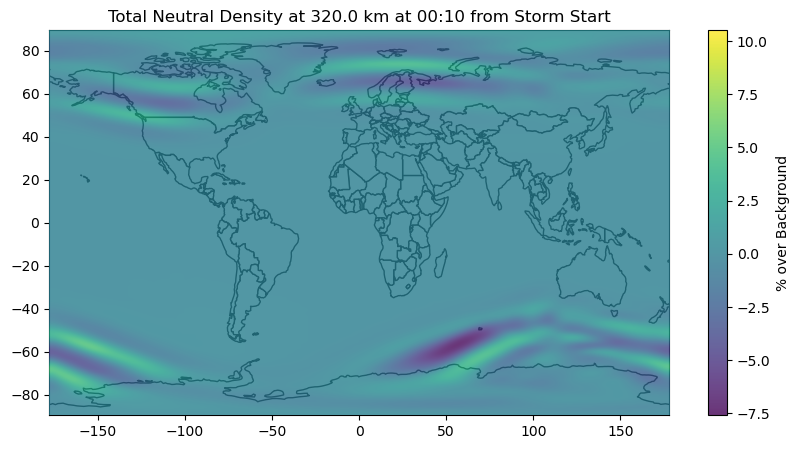

In [31]:
# [0,0,:,:,5]
call_maps(28, dtime_index = 50, numcol = 0, save_or_show='show', figtype='diff')

In [416]:
#USAGE

# call_maps(alt_idx = 5,  dtime_index = 14, numcol = 0,  save_or_show = 'save', figtype = 'all')
# loop_maps(gitm_cols, gitm_alt_idxs, thread = False)

In [425]:

loop_maps(gitm_cols, gitm_alt_idxs, save_or_show='save', thread = True)

thread is True. Building array and launching pool... (pbar is just an estimate. It will not be 100% accurate since we're threading.)


threading map making:   0%|          | 0/266400 [00:00<?, ?it/s]

/home/axb170054/scratch/made_plots/SimStormPaper/maps/raw/212/TotalNeutralDensity/084.png/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass/212/TotalNeutralDensity/067.png/home/axb170054/scratch/made_plots/SimStormPaper/maps/percent-over-filter/212/TotalNeutralDensity/052.png/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass/212/TotalNeutralDensity/070.png

Process ForkPoolWorker-824:
Process ForkPoolWorker-829:
Process ForkPoolWorker-823:


Process ForkPoolWorker-822:


/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass/212/TotalNeutralDensity/071.png

Exception ignored in: Process ForkPoolWorker-806:
Process ForkPoolWorker-810:


Process ForkPoolWorker-800:
Process ForkPoolWorker-797:


/home/axb170054/scratch/made_plots/SimStormPaper/maps/percent-over-filter/212/TotalNeutralDensity/054.png

Traceback (most recent call last):


/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass/212/TotalNeutralDensity/078.png/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass/212/TotalNeutralDensity/073.png

  File "/home/axb170054/.conda/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-809:
Process ForkPoolWorker-807:
Traceback (most recent call last):
<function BaseGeometry.__del__ at 0x2b49dedd7820>  File "/home/axb170054/.conda/envs/py38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  File "/home/axb170054/.conda/envs/py38/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_28052/3715868547.py", line 107, in thread_call_maps
    call_maps(alt_idx=args[0], namecol = args[1], dtime_real = args[2], outliers = args[3],  save_or_show = 'save', return_figs = False, figtype = 'all')


Process ForkPoolWorker-818:
Traceback (most recent call last):


  File "/tmp/ipykernel_28052/3715868547.py", line 102, in call_maps
    draw_map(percent, title, cbarlims, save_or_show= save_or_show, cbar_label = cbar_label, fname = fname)
  File "/home/axb170054/.conda/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):


/home/axb170054/scratch/made_plots/SimStormPaper/maps/percent-over-filter/212/TotalNeutralDensity/053.png

  File "/tmp/ipykernel_28052/3715868547.py", line 13, in draw_map
    fig.colorbar(data, label = cbar_label)
Traceback (most recent call last):


  File "/home/axb170054/.conda/envs/py38/lib/python3.8/site-packages/matplotlib/figure.py", line 1199, in colorbar
    cax, kw = cbar.make_axes_gridspec(ax, **kw)


/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass/212/TotalNeutralDensity/066.png

Traceback (most recent call last):
  File "/home/axb170054/.conda/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [ ]:
gitm_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/keos-outliers/"
gitm_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/maps-outliers/"

In [ ]:
loop_keos(sel_cols = gitm_cols, sel_alts = gitm_alt_idxs, sel_lons = gitm_keo_lons, debug = False, save_or_show = 'save', thread = True, outliers = True)

In [ ]:
loop_maps(gitm_cols, gitm_alt_idxs, save_or_show='save', thread = True, outliers = True)

In [ ]:
def make_gitm_lon_plot(alt_idx, lon_idx, dtime_index, save_or_show = 'show', return_figs = False, figtype = 'all', outliers = False):
    #make sure inputs are lists so we can loop through them.
    if type(alt_idx) is not list: 
        if type(alt_idx) is not np.array:
            alt_idx = [ alt_idx ]
    if type(lon_idx) is not list: 
        if type(lon_idx) is not np.array:
            lon_idx = [ lon_idx ]
    if type(dtime_index) is not list: 
        if type(dtime_index) is not np.array:
            dtime_index = [ dtime_index ]
    
    for nalt in alt_idx:
        for nlon in lon_idx:
            for dtime_index in dtime_index:
                dtime_real = times[dtime_index]
                
                real_lon = gitm_lons[nlon]
                #get raw data
                raw = gitm_data[dtime_index, nalt, nlon, :, dtime_index]
                

In [ ]:
def make_gitm_lon_plots():
    #make a plot for each gitm column at each altitude, for each longitude.
    for namecol in gitm_cols:
        numcol = gitm_cols.index(namecol)
        for nalt in gitm_alt_idxs:
            for lon in gitm_keo_lons:
                make_gitm_lon_plot(nalt, lon, numcol, save_or_show='save', return_figs = False)